In [328]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('fivethirtyeight')

from os import listdir
from os.path import isfile, join

import re

In [329]:
def removeExtension(file_name):
    idx = -1
    for i, c in enumerate(file_name):
        if c == '.':
            idx = i
            break
    if idx >= 0:
        return file_name[:idx]
    return file_name

In [330]:
SUBMISSIONS_DIR = './single_submissions/'
MATCH_RESULTS_DIR = './final_match_results/'

In [331]:
files = sorted([f for f in listdir(SUBMISSIONS_DIR) if isfile(join(SUBMISSIONS_DIR, f)) and f[-1] != 'c'])
names = sorted([removeExtension(f) for f in files])

teams = list(zip(files, names))

In [332]:
match_results_df = pd.DataFrame(columns=['Team', 'Opponent', 'Wins', 'Losses', 'Ties', 'Invalid'])

In [333]:
def process_raw_outcome(outcome):
    return outcome.replace('\n', '')

for i in range(len(teams)):
    for j in range(i + 1, len(teams)):
        if i == j:
            continue
        
        file_a, name_a = teams[i]
        file_b, name_b = teams[j]
        
        # Get match results for team a vs team b
        match_data_file_name = name_a + '_vs_' + name_b + '.dat'
        try:
            match_data_file = open(join(MATCH_RESULTS_DIR, match_data_file_name), 'r')
        except FileNotFoundError:
            continue
        outcomes = [process_raw_outcome(l) for l in match_data_file]
        outcomes = outcomes[:15]
        match_data_file.close()
        
        # Get DataFrame props
        num_rows, num_cols = match_results_df.shape
        
        # Insert row if doesn't exist or reset row
        index_a, index_b = -1, -1
        for k in range(num_rows):
            row = match_results_df.loc[k]
            if row.Team == name_a and row.Opponent == name_b:
                index_a = k
            if row.Team == name_b and row.Opponent == name_a:
                index_b = k
        if index_a == -1 and index_b == -1:
            index_a, index_b = num_rows, num_rows + 1
        elif index_a == -1:
            index_a = num_rows
        elif index_b == -1:
            index_b == num_rows
        
        win, loss, tied, invalid = 0, 0, 0, 0
        for outcome in outcomes:
            if outcome == name_a:
                win += 1
            elif outcome == name_b:
                loss += 1
            elif outcome == 'tied':
                tied += 1
            elif outcome == 'invalid':
                invalid += 1
            else:
                raise Error('Invalid match outcome')
        match_results_df.loc[index_a] = [name_a, name_b, win, loss, tied, invalid]
        match_results_df.loc[index_b] = [name_b, name_a, loss, win, tied, invalid]

In [334]:
match_results_df.shape

(462, 6)

In [335]:
match_results_df.head()

,Team,Opponent,Wins,Losses,Ties,Invalid
0,PacBot_Kevin_Cao,baselineTeam2_Rachel_Li,5,10,0,0
1,baselineTeam2_Rachel_Li,PacBot_Kevin_Cao,10,5,0,0
2,PacBot_Kevin_Cao,baselineTeam2_Raghav_Anand,9,6,0,0
3,baselineTeam2_Raghav_Anand,PacBot_Kevin_Cao,6,9,0,0
4,PacBot_Kevin_Cao,cleverTeam_Dylan_Rowe,10,5,0,0


In [336]:
match_results_df[match_results_df['Invalid'] > 10].shape

(0, 6)

# Invalid Submissions

In [337]:
invalid_dict = dict(zip(names, [0] * len(names)))
for file, name in teams:
    invalids = match_results_df[(match_results_df['Invalid'] > 10) & (match_results_df['Team'] == name)].shape[0]
    invalid_dict[name] += invalids
    
INVALID_THRESH = 5
invalid_list = [name for name in names if invalid_dict[name] > INVALID_THRESH]
invalid_list

[]

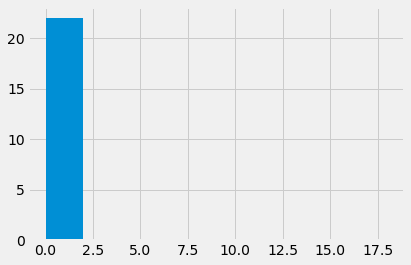

In [338]:
plt.hist(list(invalid_dict.values()), bins=np.arange(0, 20, 2))
plt.show()

# Elo

In [364]:
elo_dict = dict(zip(names, [1500] * len(names)))

In [365]:
match_results_df['margin'] = match_results_df.Wins - match_results_df.Losses

In [366]:
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))

def expected_margin(elo_diff):
    return((7.5 + 0.006 * elo_diff))

def elo_update(w_elo, l_elo, margin, K=20):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.) ** 0.8) / expected_margin(elo_diff)
    update = K * mult * (1 - pred)
    return(pred, update)

In [367]:
sample_match_results_df = match_results_df.sample(match_results_df.shape[0])

In [368]:
preds = []
w_elo = []
l_elo = []

# Loop over all rows of the games dataframe
for row in sample_match_results_df.itertuples():
    # Get key data from current row
    w = row.Team
    l = row.Opponent
    margin = row.margin
    
    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w],
                              elo_dict[l], 
                              margin)
    elo_dict[w] += update
    elo_dict[l] -= update
    
    # Save prediction and new Elos for each round
    preds.append(pred)
    w_elo.append(elo_dict[w])
    l_elo.append(elo_dict[l])

In [369]:
win_elo = []
for w in w_elo:
    if isinstance(w, complex):
        win_elo.append(w.real)
    else:
        win_elo.append(w)
        
loss_elo = []
for l in l_elo:
    if isinstance(l, complex):
        loss_elo.append(l.real)
    else:
        loss_elo.append(l)

In [370]:
sample_match_results_df['w_elo'] = win_elo
sample_match_results_df['l_elo'] = loss_elo

In [371]:
sample_match_results_df.tail(10)

,Team,Opponent,Wins,Losses,Ties,Invalid,margin,w_elo,l_elo
98,baselineTeam2_Raghav_Anand,myTeam_Colin_K_Lai_1,10,4,1,0,6,1485.203249,1488.956511
299,myTeam_Shreya_Sahoo,myTeam_ANTON_SHELBY_OYUNG_1,0,0,15,0,0,1337.144352,1390.606952
82,baselineTeam2_Raghav_Anand,cleverTeam_Dylan_Rowe,5,9,1,0,-4,1484.284571,1426.026035
123,myTeam2_SEAN_ADAM_MEDIN,cleverTeam_Dylan_Rowe,14,1,0,0,13,1723.265501,1423.677020
175,myTeam_Joshua_Yurtsever,coolTeam_SONTHAYA_VISUTHIKRAISEE,4,5,6,0,-1,1549.221254,1526.337885
268,myTeam_ANISH_SAHA,myTeam_Laura_Smith,0,8,7,0,-8,1363.776085,1621.372759
348,myTeam_Christina_Baek_1,myTeam_Xing_Jin,9,0,6,0,9,1720.642413,1526.433248
378,myTeam_DONGMIN_KANG,myTeam_Laura_Smith,1,12,2,0,-11,1332.180725,1631.892350
20,PacBot_Kevin_Cao,myTeam_Colin_K_Lai_1,10,5,0,0,5,1436.285494,1480.270924
248,myTeam3_4foodNum_ALI_KHALEEL_AHMED,myTeam_Xing_Jin,7,3,5,0,4,1689.363182,1523.370526


In [372]:
final_elo_dict = dict(zip(names, [1500] * len(names)))

In [373]:
for row in sample_match_results_df.itertuples():
    final_elo_dict[row.Team] = row.w_elo
    final_elo_dict[row.Opponent] = row.l_elo

In [374]:
rankings = zip(final_elo_dict.keys(), final_elo_dict.values())
rankings = [r for r in rankings if r[0] not in invalid_list]
rankings = sorted(list(rankings), key=lambda x: -x[1])
place = 1
for name, elo in rankings:
    print('%d.' %place, name, '(%.3f)' % elo)
    place += 1

1. myTeam2_SEAN_ADAM_MEDIN (1723.266)
2. myTeam_Christina_Baek_1 (1720.642)
3. myTeam3_4foodNum_ALI_KHALEEL_AHMED (1689.363)
4. myTeam_Laura_Smith (1631.892)
5. myTeam_SHARABESH_RAMESH (1621.550)
6. myTeam_Swapnil_Das_1 (1549.871)
7. myTeam_Joshua_Yurtsever (1549.221)
8. myTeam_Benjamin_Carlson_1 (1539.035)
9. coolTeam_SONTHAYA_VISUTHIKRAISEE (1526.338)
10. myTeam_Xing_Jin (1523.371)
11. myTeam_Julia_Luo (1486.441)
12. baselineTeam2_Raghav_Anand (1484.285)
13. myTeam_Colin_K_Lai_1 (1480.271)
14. baselineTeam2_Rachel_Li (1445.462)
15. PacBot_Kevin_Cao (1436.285)
16. cleverTeam_Dylan_Rowe (1423.677)
17. myTeam_ANTON_SHELBY_OYUNG_1 (1390.607)
18. veryCleverTeam_Gao_Xian_Peh (1373.037)
19. myTeam_Jesse_Zhang_Zhang (1372.284)
20. myTeam_ANISH_SAHA (1363.776)
21. myTeam_Shreya_Sahoo (1337.144)
22. myTeam_DONGMIN_KANG (1332.181)


# Manual Investigation

In [375]:
match_results_df[match_results_df['Team'] == 'myTeam2_SEAN_ADAM_MEDIN']

,Team,Opponent,Wins,Losses,Ties,Invalid,margin,w_elo,l_elo
9,myTeam2_SEAN_ADAM_MEDIN,PacBot_Kevin_Cao,14,1,0,0,13,1518.703972,1492.796535
49,myTeam2_SEAN_ADAM_MEDIN,baselineTeam2_Rachel_Li,11,0,4,0,11,1534.475962,1480.918982
87,myTeam2_SEAN_ADAM_MEDIN,baselineTeam2_Raghav_Anand,8,0,7,0,8,1546.188778,1470.291665
123,myTeam2_SEAN_ADAM_MEDIN,cleverTeam_Dylan_Rowe,14,1,0,0,13,1563.836311,1497.053899
157,myTeam2_SEAN_ADAM_MEDIN,coolTeam_SONTHAYA_VISUTHIKRAISEE,14,0,1,0,14,1581.767778,1477.171142
190,myTeam2_SEAN_ADAM_MEDIN,myTeam3_4foodNum_ALI_KHALEEL_AHMED,8,1,6,0,7,1588.774362,1527.586578
192,myTeam2_SEAN_ADAM_MEDIN,myTeam_ANISH_SAHA,14,1,0,0,13,1600.976141,1488.648083
194,myTeam2_SEAN_ADAM_MEDIN,myTeam_ANTON_SHELBY_OYUNG_1,15,0,0,0,15,1618.535587,1483.775425
196,myTeam2_SEAN_ADAM_MEDIN,myTeam_Benjamin_Carlson_1,11,0,4,0,11,1636.719529,1508.258120
198,myTeam2_SEAN_ADAM_MEDIN,myTeam_Christina_Baek_1,3,4,8,0,-1,1646.388325,1566.389481
